In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [328]:
data = pd.read_csv('delhivery_data.csv')
data.shape

(144867, 24)

In [329]:
data.head()

,data,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,...,cutoff_timestamp,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor
0,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 04:27:55,10.435660,14.0,11.0,11.9653,1.272727,14.0,11.0,11.9653,1.272727
1,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 04:17:55,18.936842,24.0,20.0,21.7243,1.200000,10.0,9.0,9.7590,1.111111
2,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 04:01:19.505586,27.637279,40.0,28.0,32.5395,1.428571,16.0,7.0,10.8152,2.285714
3,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 03:39:57,36.118028,62.0,40.0,45.5620,1.550000,21.0,12.0,13.0224,1.750000
4,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 03:33:55,39.386040,68.0,44.0,54.2181,1.545455,6.0,5.0,3.9153,1.200000


In [330]:
#List of all columns
data.columns

Index(['data', 'trip_creation_time', 'route_schedule_uuid', 'route_type',
       'trip_uuid', 'source_center', 'source_name', 'destination_center',
       'destination_name', 'od_start_time', 'od_end_time',
       'start_scan_to_end_scan', 'is_cutoff', 'cutoff_factor',
       'cutoff_timestamp', 'actual_distance_to_destination', 'actual_time',
       'osrm_time', 'osrm_distance', 'factor', 'segment_actual_time',
       'segment_osrm_time', 'segment_osrm_distance', 'segment_factor'],
      dtype='object')

In [332]:
#Checking data types 
data.dtypes

data                               object
trip_creation_time                 object
route_schedule_uuid                object
route_type                         object
trip_uuid                          object
source_center                      object
source_name                        object
destination_center                 object
destination_name                   object
od_start_time                      object
od_end_time                        object
start_scan_to_end_scan            float64
is_cutoff                            bool
cutoff_factor                       int64
cutoff_timestamp                   object
actual_distance_to_destination    float64
actual_time                       float64
osrm_time                         float64
osrm_distance                     float64
factor                            float64
segment_actual_time               float64
segment_osrm_time                 float64
segment_osrm_distance             float64
segment_factor                    

In [333]:
#Converting time related columns to datetime datatype 
data['od_start_time'] =  pd.to_datetime(data['od_start_time'])
data['od_end_time'] =  pd.to_datetime(data['od_end_time'])

In [334]:
#Get the time difference between start and end trips.
data['start_end_trip'] = (data['od_end_time'] - data['od_start_time']) / pd.Timedelta(minutes=1)

In [335]:
#Dropping unkinown fields from the data.
#Dropping start and end time as total time taken is captured in 'start_scan_to_end_scan'.
data = data.drop(['od_start_time','od_end_time','is_cutoff','cutoff_factor','cutoff_timestamp','factor','segment_factor'], axis = 1)

In [336]:
#converting cumulative sum columns into normal values for merging of a data
data['actual_distance_to_destination'] = data.groupby(['trip_uuid','source_center','destination_center'])['actual_distance_to_destination'].diff().fillna(data['actual_distance_to_destination'][0])
data['actual_time'] = data.groupby(['trip_uuid','source_center','destination_center'])['actual_time'].diff().fillna(data['actual_time'][0])
data['osrm_time'] = data.groupby(['trip_uuid','source_center','destination_center'])['osrm_time'].diff().fillna(data['osrm_time'][0])
data['osrm_distance'] = data.groupby(['trip_uuid','source_center','destination_center'])['osrm_distance'].diff().fillna(data['osrm_distance'][0])

In [337]:
#Merging the data on the basis of trip uuid, source_center and destination center
aggregation_functions = {'trip_creation_time': 'first',
                         'route_type': 'first',
                         'source_name': 'first',
                         'destination_name': 'last',
                         'start_end_trip': 'first',
                         'start_scan_to_end_scan': 'first',
                         'actual_distance_to_destination': 'sum',
                         'actual_time': 'sum',
                         'osrm_time': 'sum',
                         'osrm_distance': 'sum',
                         'segment_actual_time': 'sum',
                         'segment_osrm_time': 'sum',
                         'segment_osrm_distance': 'sum'
                        }
data_new = data.groupby(['trip_uuid','source_center','destination_center'],sort=False, as_index=False).agg(aggregation_functions)

In [338]:
#Merging the data further on the basis of trip_uuid
aggregation_functions = {'trip_creation_time': 'first',
                         'route_type': 'first',
                         'source_name': 'first',
                         'destination_name': 'last',
                         'start_end_trip': 'sum',
                         'start_scan_to_end_scan': 'sum',
                         'actual_distance_to_destination': 'sum',
                         'actual_time': 'sum',
                         'osrm_time': 'sum',
                         'osrm_distance': 'sum',
                         'segment_actual_time': 'sum',
                         'segment_osrm_time': 'sum',
                         'segment_osrm_distance': 'sum'
                        }
data_latest = data_new.groupby(['trip_uuid'],sort=False, as_index=False).agg(aggregation_functions)

In [339]:
data_latest.head()

,trip_uuid,trip_creation_time,route_type,source_name,destination_name,start_end_trip,start_scan_to_end_scan,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,segment_actual_time,segment_osrm_time,segment_osrm_distance
0,trip-153741093647649320,2018-09-20 02:35:36.476840,Carting,Anand_VUNagar_DC (Gujarat),Anand_Vaghasi_IP (Gujarat),195.386819,195.0,83.014464,169.0,89.0,107.2997,167.0,88.0,102.7106
1,trip-153768492602129387,2018-09-23 06:42:06.021680,FTL,Bhiwandi_Mankoli_HB (Maharashtra),Pune_Tathawde_H (Maharashtra),302.372403,302.0,87.949749,159.0,82.0,114.4550,180.0,106.0,130.4089
2,trip-153693976643699843,2018-09-14 15:42:46.437249,Carting,LowerParel_CP (Maharashtra),Mumbai_Chndivli_PC (Maharashtra),108.982192,108.0,17.511081,28.0,16.0,19.3250,60.0,16.0,18.7941
3,trip-153687145942424248,2018-09-13 20:44:19.424489,FTL,Bangalore_Nelmngla_H (Karnataka),Aluva_Peedika_H (Kerala),1031.655681,1031.0,344.374081,753.0,454.0,489.9650,799.0,502.0,560.5092
4,trip-153825970514894360,2018-09-29 22:21:45.149226,FTL,Ludhiana_GillChwk_DC (Punjab),Ludhiana_MilrGanj_HB (Punjab),262.636371,261.0,60.517591,82.0,60.0,79.8031,151.0,137.0,115.7501


In [340]:
data_latest.dtypes

trip_uuid                          object
trip_creation_time                 object
route_type                         object
source_name                        object
destination_name                   object
start_end_trip                    float64
start_scan_to_end_scan            float64
actual_distance_to_destination    float64
actual_time                       float64
osrm_time                         float64
osrm_distance                     float64
segment_actual_time               float64
segment_osrm_time                 float64
segment_osrm_distance             float64
dtype: object

In [341]:
#Converting trip_creation_time to datetime datatype 
data_latest['trip_creation_time'] =  pd.to_datetime(data_latest['trip_creation_time'])

In [342]:
#Creation of new features for better analysis of data
data_latest['year'] = pd.DatetimeIndex(data_latest['trip_creation_time']).year
data_latest['month'] = pd.DatetimeIndex(data_latest['trip_creation_time']).month
data_latest['day'] = pd.DatetimeIndex(data_latest['trip_creation_time']).day

In [343]:
#Fetch the data of state and city and create new features
data_latest['source_state'] = data_latest['source_name'].str.split(' ').str[1].str.strip('()')
data_latest['source_city'] = data_latest['source_name'].str.split('_').str[-3]
data_latest['source_corridor'] = data_latest['source_name'].str.split(' ').str[0].str.strip('()')

data_latest['destination_state'] = data_latest['destination_name'].str.split(' ').str[1].str.strip('()')
data_latest['destination_city'] = data_latest['destination_name'].str.split('_').str[-3]
data_latest['destination_corridor'] = data_latest['destination_name'].str.split(' ').str[0].str.strip('()')

In [344]:
data_latest.isna().sum()

trip_uuid                            0
trip_creation_time                   0
route_type                           0
source_name                         10
destination_name                     8
start_end_trip                       0
start_scan_to_end_scan               0
actual_distance_to_destination       0
actual_time                          0
osrm_time                            0
osrm_distance                        0
segment_actual_time                  0
segment_osrm_time                    0
segment_osrm_distance                0
year                                 0
month                                0
day                                  0
source_state                        10
source_city                       1824
source_corridor                     10
destination_state                    8
destination_city                  1733
destination_corridor                 8
dtype: int64

In [345]:
#Handling missing values - As per analysis of data most of the time places are from same cities in both source and destination.
#As other missing values are less in numbers we will replace then with 'Others' instead of removing.
data_latest['source_city'] = data_latest['source_city'].fillna(data_latest['destination_city'])
data_latest['destination_city'] = data_latest['destination_city'].fillna(data_latest['source_city'])

data_latest['source_state'] = data_latest['source_state'].fillna(data_latest['destination_state'])
data_latest['destination_state'] = data_latest['destination_state'].fillna(data_latest['source_state'])

data_latest['source_city'] = data_latest['source_city'].fillna('Other')
data_latest['destination_city'] = data_latest['destination_city'].fillna('Other')

data_latest['source_state'] = data_latest['source_state'].fillna('Other')
data_latest['destination_state'] = data_latest['destination_state'].fillna('Other')

data_latest['source_corridor'] = data_latest['destination_city'].fillna('Other')
data_latest['source_corridor'] = data_latest['destination_city'].fillna('Other')

data_latest = data_latest.drop(['source_name','destination_name'], axis=1)

In [346]:
data_latest.isna().sum()

trip_uuid                         0
trip_creation_time                0
route_type                        0
start_end_trip                    0
start_scan_to_end_scan            0
actual_distance_to_destination    0
actual_time                       0
osrm_time                         0
osrm_distance                     0
segment_actual_time               0
segment_osrm_time                 0
segment_osrm_distance             0
year                              0
month                             0
day                               0
source_state                      0
source_city                       0
source_corridor                   0
destination_state                 0
destination_city                  0
destination_corridor              8
dtype: int64

In [347]:
data_latest.describe()

,start_end_trip,start_scan_to_end_scan,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,segment_actual_time,segment_osrm_time,segment_osrm_distance,year,month,day
count,14817.000000,14817.000000,14817.000000,14817.000000,14817.000000,14817.000000,14817.000000,14817.000000,14817.000000,14817.0,14817.000000,14817.000000
mean,531.697682,530.810016,150.981408,301.139097,144.568266,184.721685,353.892286,180.949787,223.201161,2018.0,9.120672,18.370790
std,658.868299,658.705957,298.201997,541.010810,263.750773,361.377595,556.247965,314.542047,416.628374,0.0,0.325757,7.893275
min,23.461468,23.000000,9.087913,14.000000,-19.000000,-15.449800,9.000000,6.000000,9.072900,2018.0,9.000000,1.000000
25%,149.930591,149.000000,22.597857,48.000000,25.000000,27.100300,66.000000,31.000000,32.654500,2018.0,9.000000,14.000000
50%,280.765626,280.000000,44.270405,107.000000,51.000000,54.080600,147.000000,65.000000,70.154400,2018.0,9.000000,19.000000
75%,638.199071,637.000000,131.221338,279.000000,134.000000,163.400800,367.000000,185.000000,218.802400,2018.0,9.000000,25.000000
max,7898.551955,7898.000000,2148.891345,6218.000000,2018.000000,2814.263600,6230.000000,2564.000000,3523.632400,2018.0,10.000000,30.000000


In [348]:
# catgeorical features
data_latest.describe(include = ['object'])

,trip_uuid,route_type,source_state,source_city,source_corridor,destination_state,destination_city,destination_corridor
count,14817,14817,14817,14817,14817,14817,14817,14809
unique,14817,2,48,564,636,49,636,947
top,trip-153741093647649320,Carting,Maharashtra,Central,Bengaluru,Maharashtra,Bengaluru,Gurgaon_Bilaspur_HB
freq,1,8908,2290,1086,1135,2203,1135,813


1. Average trip start and end time is 627 minutes.
2. Average time aand distnce taken to complete the delivery is 107 minutes and 131 kms resp.
3. Most orders are coming from Maharashtra state and Gurgaon_Bilaspur_HB corridor.
4. Given data is from year 2018 and maximum orders were placed in September month.

In [349]:
data_latest['route_type'].value_counts()

Carting    8908
FTL        5909
Name: route_type, dtype: int64

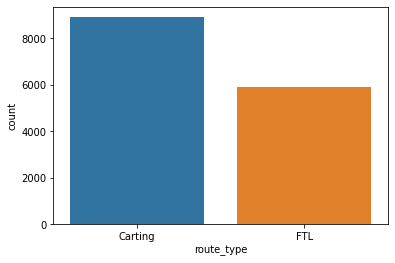

In [350]:
sns.countplot(data=data_latest, x='route_type')
plt.show()

Cartering is more preferred route type for the delivery

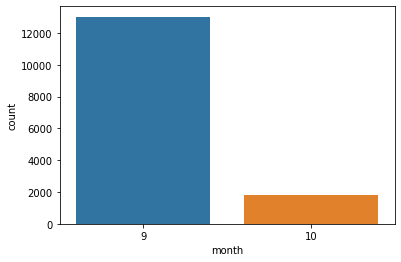

In [351]:
sns.countplot(data=data_latest, x='month')
plt.show()

maximum orders were placed in September month.

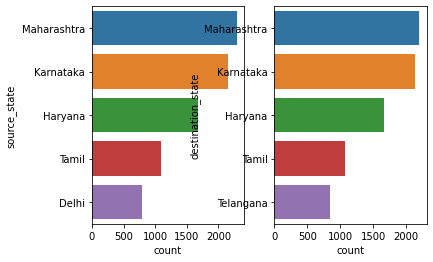

In [353]:
plt.subplot(121)
sns.countplot(data=data_latest, y='source_state',order=data_latest['source_state'].value_counts().index[:5])

plt.subplot(122)
sns.countplot(data=data_latest, y='destination_state',order=data_latest['destination_state'].value_counts().index[:5])
plt.show()

Most orders are coming from Maharashtra state.

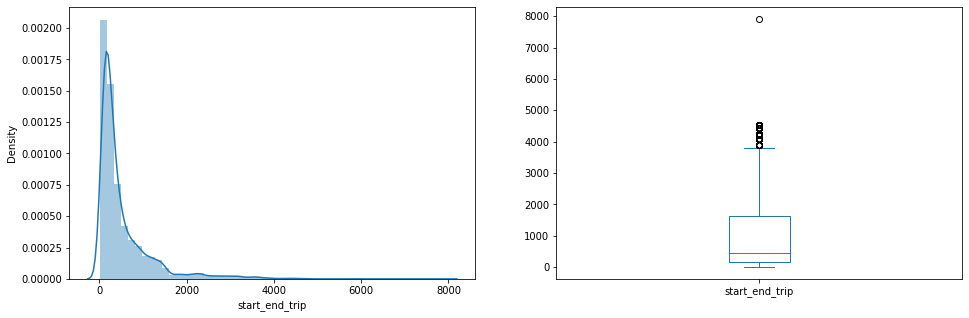

In [302]:
plt.subplot(121)
sns.distplot(data_latest["start_end_trip"])

plt.subplot(122)
data["start_end_trip"].plot.box(figsize=(16,5))
plt.show()

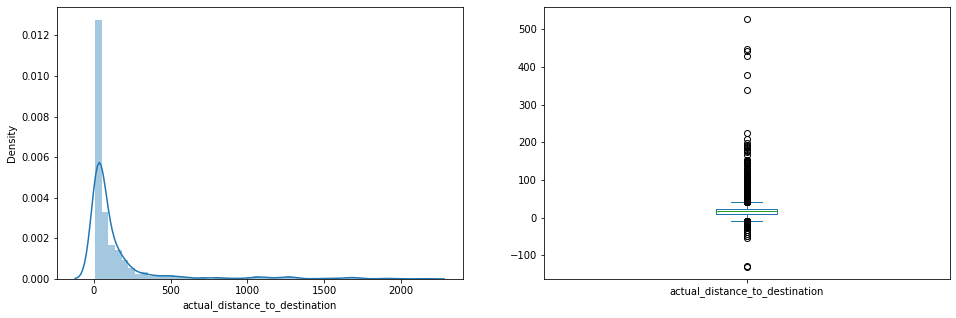

In [303]:
plt.subplot(121)
sns.distplot(data_latest["actual_distance_to_destination"])

plt.subplot(122)
data["actual_distance_to_destination"].plot.box(figsize=(16,5))
plt.show()

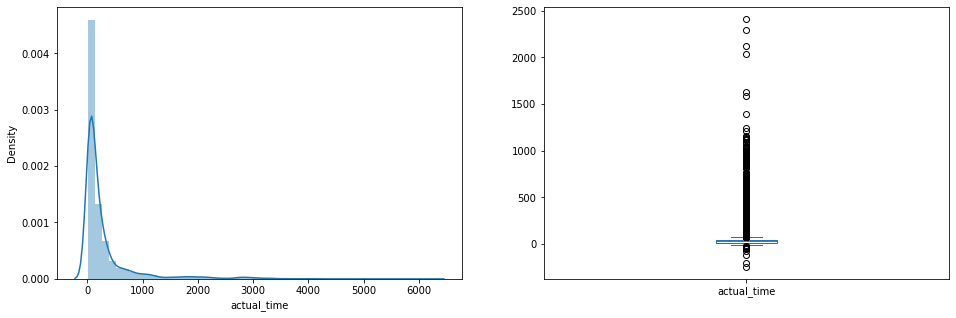

In [304]:
plt.subplot(121)
sns.distplot(data_latest["actual_time"])

plt.subplot(122)
data["actual_time"].plot.box(figsize=(16,5))
plt.show()

As there is a possibility that due to some incidents like rain or traveeling issues, some of the deliveries might get delayed, so the outliers might not be removed.

###### Setting up Null Heypothesis and Alternate Hypothesis
H0 : mean of start_end_trip time and start_scan_to_end_scan time is same

H1 : mean of start_end_trip time and start_scan_to_end_scan time is different

In [305]:
var1 = data_latest['start_end_trip']
var2 = data_latest['start_scan_to_end_scan']

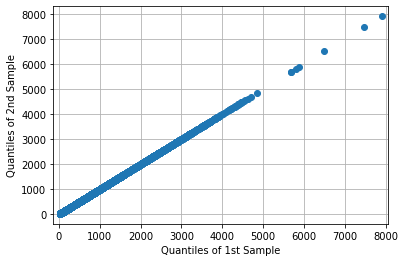

In [306]:
#QQPlot to check normality.
from statsmodels.graphics.gofplots import qqplot_2samples
qqplot_2samples(var1, var2)
plt.grid()

In [307]:
# Test statistic for T test
stats.ttest_ind(var1, var2)

Ttest_indResult(statistic=0.11597642119208701, pvalue=0.9076720147410308)

By comparing pvalue with significance level of 0.05, we fail to reject the null hypothesis.

Trip time and delivery time is almost same.

#### Setting up Null Heypothesis and Alternate Hypothesis

H0 : mean of actual time and osrm time is same

H1 : mean of actual time and osrm time is different

In [308]:
var1 = data_latest['actual_time']
var2 = data_latest['osrm_time']

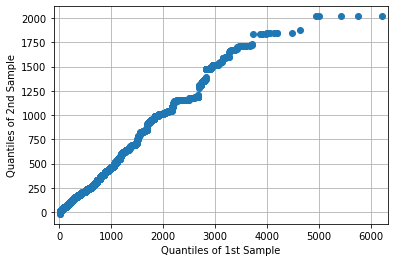

In [309]:
#QQPlot to check normality.
from statsmodels.graphics.gofplots import qqplot_2samples
qqplot_2samples(var1, var2)
plt.grid()

The given observations follows normal distribution

In [310]:
# Test statistic for T test
stats.ttest_ind(var1, var2)

Ttest_indResult(statistic=31.665219544445282, pvalue=1.907003424130859e-216)

By comparing pvalue with significance level of 0.05, we rejects the null hypothesis.

There is a difference in actual time and osrm time.
As physical travel differes continuously on map, so we may not always achieve the osrm time.

##### Setting up Null Heypothesis and Alternate Hypothesis
H0 : mean of actual time and segment actual time is same

H1 : mean of actual time and segment actual time is different

In [35]:
var1 = data_latest['actual_time']
var2 = data_latest['segment_actual_time']

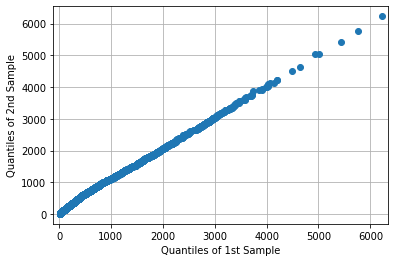

In [36]:
#QQPlot to check normality.
from statsmodels.graphics.gofplots import qqplot_2samples
qqplot_2samples(var1, var2)
plt.grid()

In [37]:
# Test statistic for T test
stats.ttest_ind(var1, var2)

Ttest_indResult(statistic=-8.275474854989543, pvalue=1.3325339495061543e-16)

By comparing pvalue with significance level of 0.05, we rejects the null hypothesis.

There is difference in actual time and segment actual time.
There might be some local activities like different rallies or strikes which delays subsets of package deliveries.

##### Setting up Null Heypothesis and Alternate Hypothesis
H0 : mean of osrm time and segment osrm time is same

H1 : mean of osrm time and segment osrm time is different

In [311]:
var1 = data_latest['osrm_time']
var2 = data_latest['segment_osrm_time']

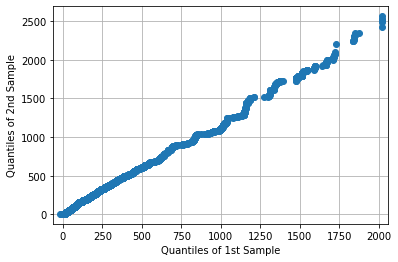

In [312]:
#QQPlot to check normality.
from statsmodels.graphics.gofplots import qqplot_2samples
qqplot_2samples(var1, var2)
plt.grid()

In [313]:
# Test statistic for T test
stats.ttest_ind(var1, var2)

Ttest_indResult(statistic=-10.788461982523827, pvalue=4.382435140127117e-27)

By comparing pvalue with significance level of 0.05, we rejects the null hypothesis.

There is difference in osrm and segment osrm time.
There might be some local activities like different rallies or strikes which delays subsets of package deliveries.

##### Setting up Null Heypothesis and Alternate Hypothesis
H0 : mean of osrm distance and segment osrm distance is same

H1 : mean of osrm distance and segment osrm distance is different

In [314]:
var1 = data_latest['osrm_distance']
var2 = data_latest['segment_osrm_distance']

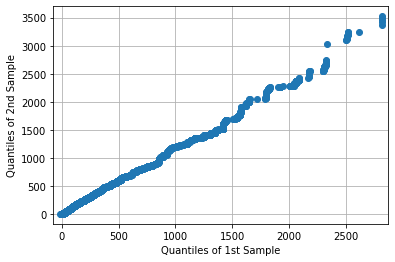

In [315]:
#QQPlot to check normality.
from statsmodels.graphics.gofplots import qqplot_2samples
qqplot_2samples(var1, var2)
plt.grid()

In [316]:
# Test statistic for T test
stats.ttest_ind(var1, var2)

Ttest_indResult(statistic=-8.492762575105319, pvalue=2.1107573064113995e-17)

By comparing pvalue with significance level of 0.05, we rejects the null hypothesis.

There is a difference in osrm distance and segment osrm distance.
There is  possibility that the the corridor in between the delivery paths were less.

##### Convert all categorical columns to numeric

In [317]:
col='route_type'
data_latest[col].value_counts()

Carting    8908
FTL        5909
Name: route_type, dtype: int64

In [318]:
from sklearn.preprocessing import LabelEncoder

data_latest[col]=data_latest[col].astype('category')
label_encoder = LabelEncoder()
data_latest[col] = label_encoder.fit_transform(data_latest[col])

In [319]:
cols=['trip_uuid','source_state','source_city','source_corridor','destination_state','destination_city',
      'destination_corridor','trip_creation_time']
for col in cols:
    data_latest[col].value_counts()

    data_latest[col]=data_latest[col].astype('category')
    label_encoder = LabelEncoder()
    data_latest[col] = label_encoder.fit_transform(data_latest[col])

In [320]:
s = (data_latest.dtypes == 'object')
object_cols = list(s[s].index)
object_cols
# No more non numeric cols.

[]

<AxesSubplot:>

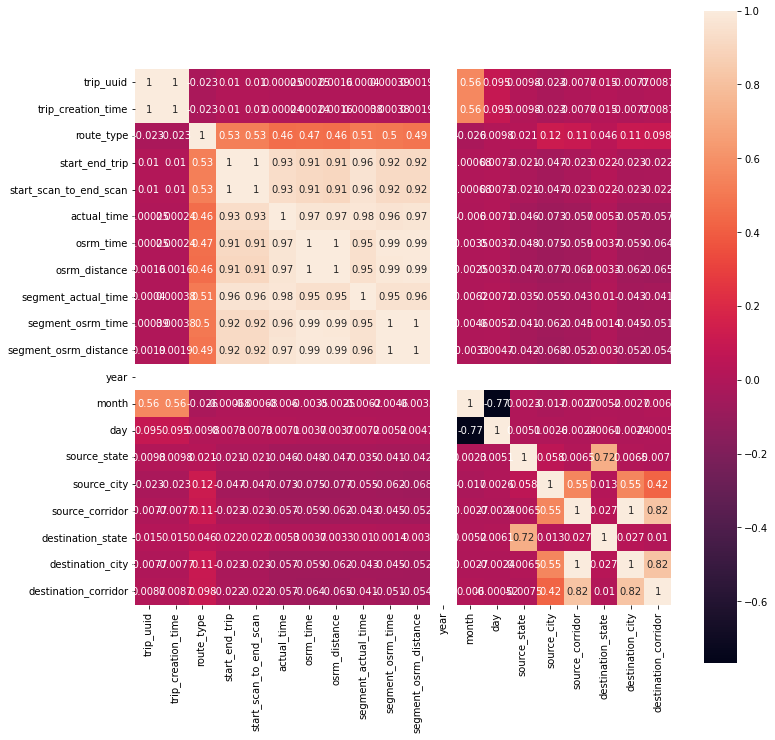

In [247]:
#PCC
plt.figure(figsize=(12, 12))
sns.heatmap(data_latest.corr(method='pearson'), square=True,annot=True)

<AxesSubplot:>

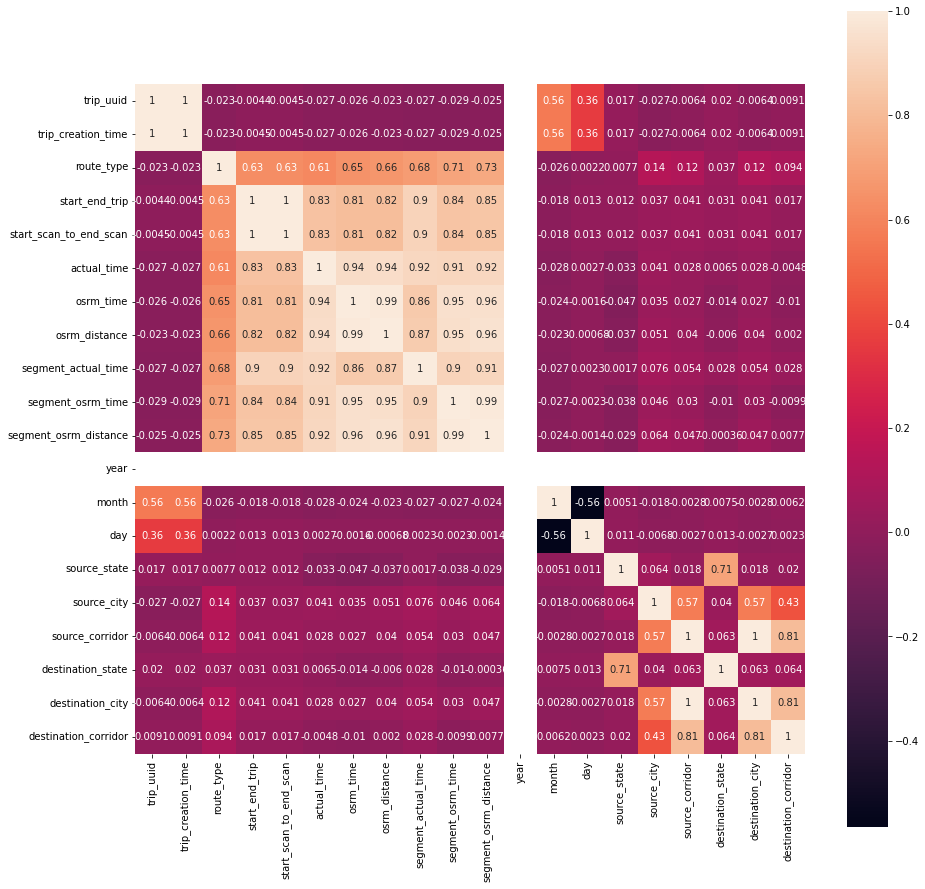

In [248]:
#SRCC
plt.figure(figsize=(15, 15))
sns.heatmap(data_latest.corr(method='spearman'), square=True,annot=True)

In [249]:
data_latest.dtypes

trip_uuid                   int64
trip_creation_time          int64
route_type                  int64
start_end_trip            float64
start_scan_to_end_scan    float64
actual_time               float64
osrm_time                 float64
osrm_distance             float64
segment_actual_time       float64
segment_osrm_time         float64
segment_osrm_distance     float64
year                        int64
month                       int64
day                         int64
source_state                int64
source_city                 int64
source_corridor             int64
destination_state           int64
destination_city            int64
destination_corridor        int64
dtype: object

In [250]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
std_data = scaler.fit_transform(data_latest)
std_data = pd.DataFrame(std_data, columns=data_latest.columns)
std_data.head()

,trip_uuid,trip_creation_time,route_type,start_end_trip,start_scan_to_end_scan,actual_time,osrm_time,osrm_distance,segment_actual_time,segment_osrm_time,segment_osrm_distance,year,month,day,source_state,source_city,source_corridor,destination_state,destination_city,destination_corridor
0,-0.348117,-0.348584,-0.814455,-0.510454,-0.509820,-0.244253,-0.210692,-0.214248,-0.335999,-0.295518,-0.289214,0.0,-0.370449,0.206412,-0.874447,-1.404531,-1.383938,-0.876266,-1.383938,-1.390438
1,0.183293,0.183293,1.227815,-0.348071,-0.347375,-0.262738,-0.237233,-0.194448,-0.312627,-0.238290,-0.222729,0.0,-0.370449,0.586495,0.082030,-0.933490,1.378069,0.108051,1.378069,1.332935
2,-1.290768,-1.290768,-0.814455,-0.641600,-0.641901,-0.504885,-0.487478,-0.457699,-0.528365,-0.524430,-0.490639,0.0,-0.370449,-0.553755,0.082030,0.950674,0.919719,0.108051,0.919719,0.839158
3,-1.426835,-1.426835,1.227815,0.758839,0.759378,0.835244,1.173237,0.844694,0.800224,1.020725,0.809641,0.0,-0.370449,-0.680449,-0.396208,-1.182469,-1.431559,-0.302081,-1.431559,-1.439815
4,1.182756,1.182756,1.227815,-0.408383,-0.409620,-0.405069,-0.320648,-0.290339,-0.364764,-0.139731,-0.257915,0.0,-0.370449,1.346661,0.958801,0.614216,0.657804,0.928315,0.657804,0.630252
